## Price Prediction using XGBoost

# Build a model

` Notes`

- ` Using XGBoost `
- ` Explore CrossValidation apart from sklearn.cross_validation eg: xgb.cv and GridSearchCV ` 
- `OneHotEncoding vs LabelEcoder`


In [128]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.grid_search import GridSearchCV

import os
# Transforming categorical features for train data
lbl = preprocessing.LabelEncoder()
enc = preprocessing.OneHotEncoder()
#models
import xgboost as xgb

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

% matplotlib inline


In [129]:
from datetime import datetime
from os.path import getmtime

IN_DIR = 'input/'
for filename in os.listdir(IN_DIR):
    print (filename,'\t' ,datetime.fromtimestamp(getmtime(os.path.join(IN_DIR, filename))).strftime('%m/%d/%Y\t%H%M'))

BAD_ADDRESS_FIX.xlsx 	 07/16/2017	2305
data_dictionary.txt 	 07/06/2017	2220
macro.csv 	 07/06/2017	2220
sample_submission.csv 	 04/11/2017	0948
test.csv 	 07/28/2017	2051
test_clean.csv 	 07/28/2017	2052
test_csv.zip 	 07/28/2017	2048
test_fe.csv 	 08/21/2017	0949
train.csv 	 07/28/2017	2052
train_clean.csv 	 07/28/2017	2053
train_csv.zip 	 07/28/2017	2048
train_fe.csv 	 08/21/2017	0949


## Introduction:

That main objective of this notebook it to build a XGBoost Model using train dataset with modified features. The test data is completely untouched as it it reserved for the Kaggle competition evaluation.

Flow of this notebook is as follows:

1. Data preprocessing
2. A basic XGBoost Model for reference
3. Extensive gridsearch cross-validaiton methods to improve the baseline score.


In [130]:
#import feature engineered data

train_df = pd.read_csv("input/train_fe.csv")
test_df = pd.read_csv("input/test_fe.csv")

train_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

## 1. Data Preprocessing

In [131]:
def corr_features():

    excluded_var={
        "young_male", "school_education_centers_top_20_raion", "0_17_female", 
        "railroad_1line", "7_14_female", "0_17_all", "children_school","ecology",
        "16_29_male", "mosque_count_3000", "female_f", "church_count_1000",
        "railroad_terminal_raion","mosque_count_5000", "big_road1_1line", "mosque_count_1000",
        "7_14_male", "0_6_female", "oil_chemistry_raion","young_all", "0_17_male", "ID_bus_terminal",
        "university_top_20_raion", "mosque_count_500","ID_big_road1","ID_railroad_terminal",
        "ID_railroad_station_walk", "ID_big_road2", "ID_metro", "ID_railroad_station_avto",
        "0_13_all", "mosque_count_2000", "work_male", "16_29_all", "young_female", "work_female",
        "0_13_female","ekder_female", "7_14_all", "big_church_count_500","leisure_count_500", 
        "cafe_sum_1500_max_price_avg", "leisure_count_2000","office_count_500", "male_f",
        "nuclear_reactor_raion", "0_6_male", "church_count_500", "build_count_before_1920",
        "thermal_power_plant_raion", "cafe_count_2000_na_price", "cafe_count_500_price_high",
        "market_count_2000", "trc_count_500", "market_count_1000",
        "work_all", "additional_education_raion","build_count_slag", "leisure_count_1000", "0_13_male",
        "office_raion","raion_build_count_with_builddate_info", "market_count_3000", "ekder_all",
        "trc_count_1000", "build_count_1946-1970","office_count_1500", "cafe_count_1500_na_price",
        "big_church_count_5000", "big_church_count_1000", "build_count_foam","church_count_1500",
        "church_count_3000", "leisure_count_1500","16_29_female", "build_count_after_1995", 
        "cafe_avg_price_1500", "office_sqm_1000", "cafe_avg_price_5000", "cafe_avg_price_2000",
        "big_church_count_1500", "full_all", "cafe_sum_5000_min_price_avg","office_sqm_2000",
        "church_count_5000","0_6_all", "detention_facility_raion", "cafe_avg_price_3000","young_male",
        "school_education_centers_top_20_raion", "0_17_female", "railroad_1line", "7_14_female", "0_17_all",
        "children_school","ecology", "16_29_male", "mosque_count_3000", "female_f", "church_count_1000",
        "railroad_terminal_raion","mosque_count_5000", "big_road1_1line", "mosque_count_1000", "7_14_male", 
        "0_6_female", "oil_chemistry_raion","young_all", "0_17_male", "ID_bus_terminal", "university_top_20_raion",
        "mosque_count_500","ID_big_road1","ID_railroad_terminal", "ID_railroad_station_walk", "ID_big_road2",
        "ID_metro", "ID_railroad_station_avto","0_13_all", "mosque_count_2000", "work_male", "16_29_all",
        "young_female", "work_female", "0_13_female","ekder_female", "7_14_all", "big_church_count_500",
        "leisure_count_500", "cafe_sum_1500_max_price_avg", "leisure_count_2000","office_count_500",
        "male_f", "nuclear_reactor_raion", "0_6_male", "church_count_500", "build_count_before_1920",
        "thermal_power_plant_raion", "cafe_count_2000_na_price", "cafe_count_500_price_high","market_count_2000",
        "trc_count_500", "market_count_1000", "work_all", "additional_education_raion",
        "build_count_slag", "leisure_count_1000", "0_13_male", "office_raion","raion_build_count_with_builddate_info",
        "market_count_3000", "ekder_all", "trc_count_1000", "build_count_1946-1970","office_count_1500",
        "cafe_count_1500_na_price", "big_church_count_5000", "big_church_count_1000", "build_count_foam",
        "church_count_1500", "church_count_3000", "leisure_count_1500","16_29_female", "build_count_after_1995",
        "cafe_avg_price_1500", "office_sqm_1000", "cafe_avg_price_5000", "cafe_avg_price_2000","big_church_count_1500",
        "full_all", "cafe_sum_5000_min_price_avg","office_sqm_2000", "church_count_5000","0_6_all",
        "detention_facility_raion", "cafe_avg_price_3000"
    }
    return excluded_var

var_drop = corr_features()

In [132]:
for var in var_drop:
    train_df.drop([var],axis=1,inplace=True)
    test_df.drop([var],axis=1,inplace=True)
    
train_df.shape, test_df.shape

((30119, 211), (7662, 210))

In [133]:
# Data preprocessing and creating of test-train split of TRAIN DATA

for col in train_df.columns:
    if train_df[col].dtype == 'object':
        lbl.fit(train_df[col].values)
        train_df[col] = lbl.transform(train_df[col].values)
  #  else:
       # train_df[col] = train_df[col]
        
# Training data test-train set preparation 
train_y = train_df['price_doc']
train_X = train_df.drop(['id', 'timestamp','price_doc'],axis=1)

In [134]:
# Data preprocessing and creating of test-train split of TEST DATA
id_test = test_df['id']
#Preparing test data
for col in test_df.columns:
    if test_df[col].dtype == 'object':
        
        lbl.fit(test_df[col].values)
        test_df[col] = lbl.transform(test_df[col].values)
   # else:
        #test_df[col] = test_df[col]
            
        
test_X = test_df.drop(['id', 'timestamp'], axis=1)

#Show the results 
print("Test data set has {} samples".format(test_X.shape))   

Test data set has (7662, 208) samples


In [135]:
print( train_X.shape, train_y.shape)

(30119, 208) (30119,)


## 2. Basic XGBOOST Model

To begin with, we develop a basic XGBoost Model. The main intention behind this is to get familiar with the parameters and entire training process. 

The XGBoost APIs for training and plotting is mentioned below:
http://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.train

We use 3-fold cross validation and for 50 trees, if the error has not improved we stop the training early after 10 rounds. The metric used for evaluation is root-mean-square-error.

In [136]:
dtrain = xgb.DMatrix(train_X, train_df['price_doc'])

** Basic list of parameters for the initial setup **


In [137]:

xgb_params_base = {
    'seed': 0,
    'eta': 0.1,
    'colsample_bytree': 0.5,
    'silent': 0,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'max_depth': 5,
    'min_child_weight': 3
}

The basic model is built by using parametes listed in **xgb_params** and is run for 50 rounds and using XGBoost built in cross validation. The train data is split into three folds and cross validated

In [138]:
xgb_base_cv1 = xgb.cv(xgb_params_base, dtrain, num_boost_round=50, nfold=3, seed=0, 
                 feval= None,
                 maximize=False, early_stopping_rounds=10)

print('Cross Validation Score:' ,xgb_base_cv1.iloc[-1,:]['test-rmse-mean'])

Cross Validation Score: 2306290.91667


      The crossvalidation score of for the test set 2306290.91667 can be starting score. Now to scale the tuning, the seeing 
      how train error and test error vary gives a better insight. 

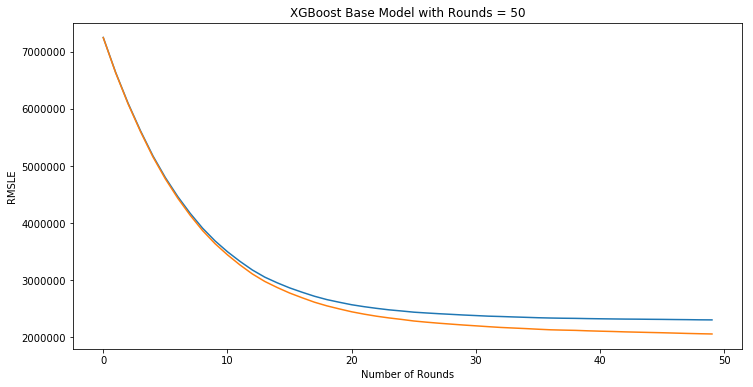

In [139]:
fig,ax =  plt.subplots(figsize= (12,6))

ax.set_title('XGBoost Base Model with Rounds = 50')
ax.plot(xgb_base_cv1[['test-rmse-mean', 'train-rmse-mean']])
ax.set_ylabel('RMSLE')
ax.set_xlabel('Number of Rounds')

plt.show()

Observing the XGBoost curves follwing infernce can be derived:

- Train and test curves are close hence there is not much overfitting
- Error is decreasing, so we can use more iterations.

This encourages us to use more number of rounds for 50 to say, 100.

In [140]:
xgb_base_cv2 = xgb.cv(xgb_params_base, dtrain, num_boost_round=100, nfold=3, seed=0, 
                 feval= None,
                 maximize=False, early_stopping_rounds=10)

print('Cross Validation Score:' ,xgb_base_cv2.iloc[-1,:]['test-rmse-mean'])

Cross Validation Score: 2256956.0


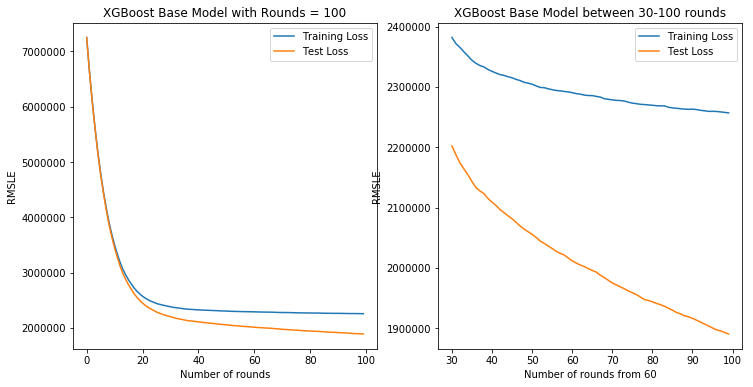

In [141]:
fig,(ax1,ax2) =  plt.subplots(figsize= (12,6), ncols=2)

ax1.set_title('XGBoost Base Model with Rounds = 100')
ax1.plot(xgb_base_cv2[['test-rmse-mean', 'train-rmse-mean']])
ax1.set_ylabel('RMSLE')
ax1.set_xlabel('Number of rounds')
ax1.legend(['Training Loss', 'Test Loss'])

ax2.set_title('XGBoost Base Model between 30-100 rounds')
ax2.plot(xgb_base_cv2.iloc[30:,][['test-rmse-mean', 'train-rmse-mean']])
ax2.set_ylabel('RMSLE')
ax2.set_xlabel('Number of rounds from 60')
ax2.legend(['Training Loss', 'Test Loss'])

plt.show()

On observing the second training data, 

The train-RMSLE is reducing from 2.051494e+06 to 1.887246e+06 whereas test-RMSLE from 2.300743e+06 to 2.250772e+06.

We can clearlysee that the model is getting overfitted as there is very less improvement in the test set. Hence it is better to stop at 50 and improve other important hyper parameters.




# XGBoost parameter tuning 

- max_depth
- min_child_wt
- gammma
- subsample
- col_sample_bytree 

For Trees size
http://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/

Other params
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

### Scorer 

For the evaluation of grid search cross calidation, we define our own scoring function.

https://stats.stackexchange.com/questions/110599/how-to-get-both-mse-and-r2-from-a-sklearn-gridsearchcv

In [142]:
def fun_rmse(y_true,dtrain):
    labels = dtrain.get_label()
    rmse = (abs(mean_squared_error(y_true=y_true,y_pred=labels)))**0.5
    return rmse
def rmse_scorer():
    return make_scorer(fun_rmse, greater_is_better=False)    

### Note:

Unfortunaltey, I am unable to get the custom scorer into the GridSearchCV,so I am planning to use sklearn built-in scorer "mean square error" and then calculate square root to get root mean square.

In [143]:
def mse2rmse(score):
    for index,_ in enumerate(score):
        val_sq = (abs(score[index][1]))**0.5
        print ('rmse: {}'.format(val_sq), 'params: {}'.format(score[index][0]))

#### Validate the work-around approach for scoring

In [144]:
xgb_params_cv = {'max_depth': [5], 'min_child_weight': [3]}

xgb_params = {
                 'colsample_bytree': 0.5,
                 'eta': 0.1,
                 'eval_metric': 'rmse',
                 'objective': 'reg:linear',
                 'seed': 0,
                 'silent': 0,
                 'subsample': 0.5,
                 'n_estimators': 50    
             }


In [145]:
valid_xgb = GridSearchCV(estimator=xgb.XGBRegressor(**xgb_params), param_grid=xgb_params_cv,scoring='mean_squared_error',
                                 cv = 5, n_jobs = -1)

In [146]:
%%time

valid_xgb.fit(train_X,train_y)

Wall time: 21.2 s


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, eta=0.1, eval_metric='rmse', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=0, subsample=0.5),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [5], 'min_child_weight': [3]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [147]:
valid_xgb.grid_scores_

[mean: -5472324861343.09082, std: 590530170485.25867, params: {'max_depth': 5, 'min_child_weight': 3}]

In [148]:
mse2rmse( valid_xgb.grid_scores_)

rmse: 2339300.0793705564 params: {'max_depth': 5, 'min_child_weight': 3}


The value of rmse calculated is close to the rmse value derived from XGBoost "eval-metric"

### Step2: Tuning max_depth and min_child_weight

In [149]:
xgb_params_cv_1 = {'max_depth': list(range(4,10)), 'min_child_weight': list(range(1,7))}

In [150]:
xgb_params_1 = {
                 'colsample_bytree': 0.5,
                 'eta': 0.1,
                 'eval_metric': 'rmse',
                 
                 'objective': 'reg:linear',
                 'seed': 0,
                 'silent': 0,
                 'subsample': 0.5,
                 'n_estimators': 50
             }

In [151]:
optimzed_xgb_1 = GridSearchCV(estimator=xgb.XGBRegressor(**xgb_params_1), param_grid=xgb_params_cv_1,scoring='mean_squared_error',
                                cv = 5, n_jobs = -1)

In [152]:
%%time
optimzed_xgb_1.fit(train_X,train_y)

Wall time: 6min 34s


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, eta=0.1, eval_metric='rmse', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=0, subsample=0.5),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [4, 5, 6, 7, 8, 9], 'min_child_weight': [1, 2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [153]:
print([{'rmse' : (abs(optimzed_xgb_1.best_score_)**0.5)}, optimzed_xgb_1.best_params_])

[{'rmse': 2315526.983498585}, {'max_depth': 8, 'min_child_weight': 6}]


In [154]:
def convert_grid_scores(scores):
    _params = []
    _params_mae = []    
    for i in scores:
        _params.append(i[0].values())
        _params_mae.append(i[1])
    params = np.array(_params)
    grid_res = np.column_stack((_params,_params_mae))
    return [grid_res[:,i] for i in range(grid_res.shape[1])]

In [155]:
_, scores_1 = convert_grid_scores(optimzed_xgb_1.grid_scores_)
scores_1 = scores_1.reshape(6,6)
scores_1 = (abs(scores_1))**0.5

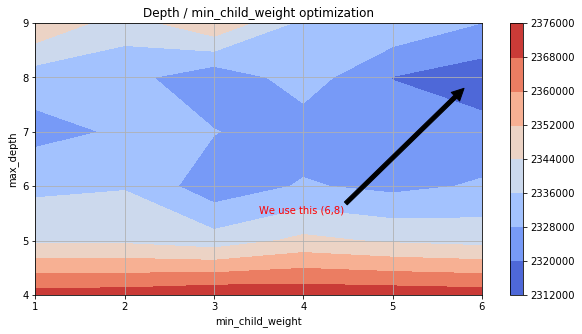

In [156]:
plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_params_cv_1['min_child_weight'], xgb_params_cv_1['max_depth'], scores_1, cmap='coolwarm')

plt.colorbar(cp)
plt.title('Depth / min_child_weight optimization')
plt.xlabel('min_child_weight')
plt.ylabel('max_depth')
plt.grid(True)

plt.annotate('We use this (6,8)', xy=(5.8, 7.8), xytext=(3.5, 5.5), arrowprops=dict(facecolor='black'), color='red')


plt.show()

### Step 3: Reducing gamma loss 

https://www.kaggle.com/c/santander-customer-satisfaction/discussion/20662#118487

In [157]:
xgb_params_cv_2 = {'gamma':[ 0.2 * i for i in range(0,6)]}

In [158]:
xgb_params_2 = {
                 'colsample_bytree': 0.5,
                 'eval_metric': 'rmse',
                 'objective': 'reg:linear',
                 'seed': 0,
                 'silent': 0,
                 'subsample': 0.5,
                 'max_depth' : 8,
                 'min_child_weight':6,
                 'n_estimators': 50
             }

In [159]:
optimzed_xgb_gamma = GridSearchCV(estimator=xgb.XGBRegressor(**xgb_params_2), param_grid=xgb_params_cv_2,
                                  scoring='mean_squared_error',cv = 5, n_jobs = -1)

In [160]:
%%time
optimzed_xgb_gamma.fit(train_X, train_y)

Wall time: 1min 32s


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, eval_metric='rmse', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=6, missing=None, n_estimators=50, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=0, subsample=0.5),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'gamma': [0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [161]:
optimzed_xgb_gamma.best_score_, optimzed_xgb_gamma.best_params_

(-5361665211310.056, {'gamma': 0.0})

In [165]:
abs(optimzed_xgb_gamma.best_score_)**0.5

2315526.983498585

Even after different set of gamma values, the error did no change much. So we will continue to use "gamma" = 0

### Step 4: Tuning subsample and colsample_bytree

In [166]:
xgb_params_cv_3 = {'subsample':[ 0.1 * i for i in range(5,10)],'colsample_bytree':[ 0.1 * i for i in range(5,10)] }

In [167]:
xgb_params_3 = {
                 'eta': 0.1,
                 'eval_metric': 'rmse',
                 'objective': 'reg:linear',
                 'seed': 0,
                 'silent': 0,
                 'max_depth' : 8,
                 'min_child_weight':6,
                 'gamma': 0,
                 'n_estimators': 50
             }

In [168]:
optimzed_xgb_3 = GridSearchCV(estimator=xgb.XGBRegressor(**xgb_params_3), param_grid=xgb_params_cv_3,
                                  scoring='mean_squared_error',cv = 5, n_jobs = -1)

In [169]:
%%time
optimzed_xgb_3.fit(train_X, train_y)

Wall time: 7min 26s


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, eval_metric='rmse', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=6, missing=None, n_estimators=50, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=0, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'colsample_bytree': [0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9], 'subsample': [0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [170]:
optimzed_xgb_3.best_score_, optimzed_xgb_3.best_params_

(-5265053287189.159,
 {'colsample_bytree': 0.6000000000000001, 'subsample': 0.9})

In [171]:
print([{'rmse' : (abs(optimzed_xgb_3.best_score_)**0.5)}, optimzed_xgb_3.best_params_])

[{'rmse': 2294570.39272914}, {'colsample_bytree': 0.6000000000000001, 'subsample': 0.9}]


In [172]:
scores_3 = convert_grid_scores(optimzed_xgb_3.grid_scores_)

_, scores_3 = convert_grid_scores(optimzed_xgb_3.grid_scores_)

scores_3 = scores_3.reshape(5,5)
scores_3 = (abs(scores_3))**0.5

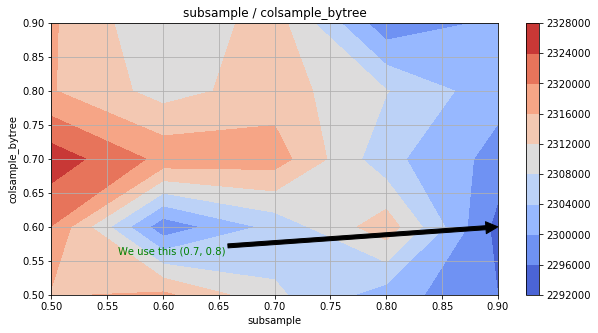

In [173]:
plt.figure(figsize=(10,5))
cp = plt.contourf(xgb_params_cv_3['subsample'], xgb_params_cv_3['colsample_bytree'], scores_3, cmap='coolwarm')

plt.colorbar(cp)
plt.title('subsample / colsample_bytree')
plt.xlabel('subsample')
plt.ylabel('colsample_bytree')
plt.grid(True)

plt.annotate('We use this (0.7, 0.8)', xy=(0.9,0.6), xytext=(0.56, 0.56), arrowprops=dict(facecolor='black'), color='green')


plt.show()

### Step 5: Reducing Learning rate and add more trees

In [174]:
xgb_params_cv_4 = {'eta':[0.2,0.1,0.075,0.05,0.04,0.030]}

In [175]:
xgb_params_4 = {
                 'eta': 0.1,
                 'eval_metric': 'rmse',
                 'objective': 'reg:linear',
                 'seed': 0,
                 'silent': 0,
                 'max_depth' : 8,
                 'min_child_weight':6,
                 'gamma': 0,
                 'subsample': 0.9,
                 'colsample_bytree': 0.6,
                'n_estimators':50
                
                 
             }

In [176]:
optimzed_xgb_4 = GridSearchCV(estimator=xgb.XGBRegressor(**xgb_params_4), param_grid=xgb_params_cv_4,
                                  scoring='mean_squared_error',cv = 5, n_jobs = -1)

In [177]:
%%time
optimzed_xgb_4.fit(train_X, train_y)

Wall time: 1min 46s


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, eta=0.1, eval_metric='rmse', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=6, missing=None, n_estimators=50, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=0, subsample=0.9),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'eta': [0.2, 0.1, 0.075, 0.05, 0.04, 0.03]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [178]:
print([{'rmse' : (abs(optimzed_xgb_4.best_score_)**0.5)}, optimzed_xgb_4.best_params_])

[{'rmse': 2294570.39272914}, {'eta': 0.2}]


#### Eta with 100 rounds

In [179]:
xgb_params_4_1 = {
                 'eta': 0.1,
                 'eval_metric': 'rmse',
                 'objective': 'reg:linear',
                 'seed': 0,
                 'silent': 0,
                 'max_depth' : 8,
                 'min_child_weight':6,
                 'gamma': 0,
                 'subsample': 0.9,
                 'colsample_bytree': 0.6,
                'n_estimators':100
                
                 
             }

In [180]:
optimzed_xgb_4_1 = GridSearchCV(estimator=xgb.XGBRegressor(**xgb_params_4_1), param_grid=xgb_params_cv_4,scoring='mean_squared_error',
                                 cv = 5, n_jobs = -1)

In [181]:
%%time
optimzed_xgb_4_1.fit(train_X, train_y)

Wall time: 3min 20s


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, eta=0.1, eval_metric='rmse', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=6, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=0, subsample=0.9),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'eta': [0.2, 0.1, 0.075, 0.05, 0.04, 0.03]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [182]:
optimzed_xgb_4_1.best_score_,optimzed_xgb_4_1.best_params_

(-5229919912560.701, {'eta': 0.2})

In [196]:
optimzed_xgb_4_1.grid_scores_,optimzed_xgb_4_1.best_score_,optimzed_xgb_4_1.best_params_

([mean: -5229919912560.70117, std: 582073809584.23560, params: {'eta': 0.2},
  mean: -5229919912560.70117, std: 582073809584.23560, params: {'eta': 0.1},
  mean: -5229919912560.70117, std: 582073809584.23560, params: {'eta': 0.075},
  mean: -5229919912560.70117, std: 582073809584.23560, params: {'eta': 0.05},
  mean: -5229919912560.70117, std: 582073809584.23560, params: {'eta': 0.04},
  mean: -5229919912560.70117, std: 582073809584.23560, params: {'eta': 0.03}],
 -5229919912560.701,
 {'eta': 0.2})

In [183]:
mse2rmse(optimzed_xgb_4_1.grid_scores_)

rmse: 2286901.8152427753 params: {'eta': 0.2}
rmse: 2286901.8152427753 params: {'eta': 0.1}
rmse: 2286901.8152427753 params: {'eta': 0.075}
rmse: 2286901.8152427753 params: {'eta': 0.05}
rmse: 2286901.8152427753 params: {'eta': 0.04}
rmse: 2286901.8152427753 params: {'eta': 0.03}


### Step 5: n_estimators

In [184]:
xgb_params_cv_5 = {'n_estimators':[50,100,150,200,250]}

In [185]:
xgb_params_5 = {
                 'eta': 0.1,
                 'eval_metric': 'rmse',
                 'objective': 'reg:linear',
                 'seed': 0,
                 'silent': 0,
                 'max_depth' : 8,
                 'min_child_weight':6,
                 'gamma': 0,
                 'subsample': 0.9,
                 'colsample_bytree': 0.6                
                 
             }

In [186]:
optimzed_xgb_5 = GridSearchCV(estimator=xgb.XGBRegressor(**xgb_params_5), param_grid=xgb_params_cv_5,scoring='mean_squared_error',
                                 cv = 5, n_jobs = -1)

In [187]:
%%time
optimzed_xgb_5.fit(train_X, train_y)

Wall time: 4min 1s


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, eta=0.1, eval_metric='rmse', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=6, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=0, subsample=0.9),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 150, 200, 250]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [189]:
optimzed_xgb_5.best_score_,optimzed_xgb_5.best_params_

(-5229919912560.701, {'n_estimators': 100})

In [190]:
mse2rmse(optimzed_xgb_5.grid_scores_)

rmse: 2294570.39272914 params: {'n_estimators': 50}
rmse: 2286901.8152427753 params: {'n_estimators': 100}
rmse: 2290809.7882970567 params: {'n_estimators': 150}
rmse: 2300060.7749741226 params: {'n_estimators': 200}
rmse: 2304774.1429865174 params: {'n_estimators': 250}


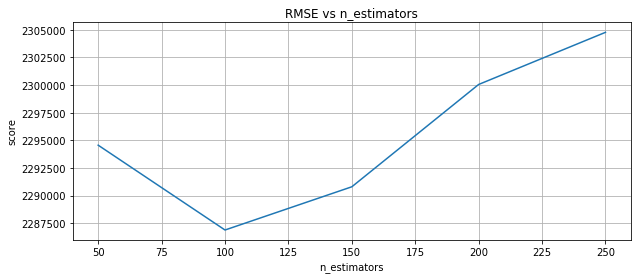

In [191]:
eta = [50,100,150,200,250]
_, loss = convert_grid_scores(optimzed_xgb_5.grid_scores_)
plt.figure(figsize=(10,4))
plt.title('RMSE vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.plot(eta, (abs(loss)**0.5))
plt.grid(True)
plt.show()

### The Best Model

In [192]:
xgb_params_best = {
                 'eta': 0.1,
                 'eval_metric': 'rmse',
                 'objective': 'reg:linear',
                 'seed': 0,
                 'silent': 0,
                 'max_depth' : 8,
                 'min_child_weight':6,
                 'gamma': 0,
                 'subsample': 0.9,
                 'colsample_bytree': 0.6,
                 'n_estimators': 100
                 
             }

In [193]:
%%time 
xgb_best = xgb.cv(xgb_params_best, dtrain, num_boost_round=100, nfold=5, seed=0, 
                 feval= None,
                 maximize=False, early_stopping_rounds=10)

Wall time: 2min 2s


In [194]:
print('Cross Validation Score:' ,xgb_best.iloc[-1,:]['test-rmse-mean'])

#xgb_best.describe()

Cross Validation Score: 2211680.0


In [195]:
xgb_best.describe()

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
count,1.000000e+02,100.000000,1.000000e+02,100.000000
mean,2.589393e+06,41401.105030,1.964309e+06,16781.816096
std,9.484248e+05,2655.997475,1.163532e+06,3906.177300
min,2.211320e+06,33512.998525,1.291719e+06,9431.469738
25%,2.215666e+06,40022.677025,1.383832e+06,13394.186051
50%,2.228535e+06,41369.189196,1.516005e+06,16899.353346
75%,2.333950e+06,43349.472115,1.847104e+06,19804.604930
max,7.242316e+06,45966.217176,7.234312e+06,24069.093051
